## Quantum energy teleportation protocol to storage energy

### Import packages

In [29]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

### Function to generate a circuit that measures the interaction term $X_0X_1$ or $V$

In [30]:
def qc_V(h_A,h_B,k):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,qr[0])
    qc.cx(qr[0],qr[1])
    qc.barrier()

    # Alice's projective measurement
    qc.h(qr[0])
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k))

    qc.cry(np.pi + 2*phi,qr[0],qr[2])
    
    qc.x(qr[0])
    qc.cry(np.pi - 2*phi,qr[0],qr[2])
    qc.x(qr[0])
    qc.barrier()

    #Bob's conditional operation
    qc.cry(-2*phi,qr[0],qr[1])
    
    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # measurament of qubit B and C
    qc.h(qr[1])
    qc.measure_all()

    return qc

### Function to generate a circuit that measures the local term $Z_1$ or $H_1$

In [31]:
def qc_H(h_A,h_B,k):
    qr = QuantumRegister(3)
    qc = QuantumCircuit(qr)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,qr[0])
    qc.cx(qr[0],qr[1])
    qc.barrier()

    # Alice's projective measurement
    qc.h(qr[0])
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k))

    qc.cry(np.pi + 2*phi,qr[0],qr[2])
    
    qc.x(qr[0])
    qc.cry(np.pi - 2*phi,qr[0],qr[2])
    qc.x(qr[0])
    qc.barrier()

    #Bob's conditional operation
    qc.cry(-2*phi,qr[0],qr[1])
    
    qc.x(qr[0])
    qc.cry(2*phi,qr[0],qr[1])
    qc.x(qr[0])

    # measurament of qubit B and C
    qc.measure_all()

    return qc

### Show quantum circuit

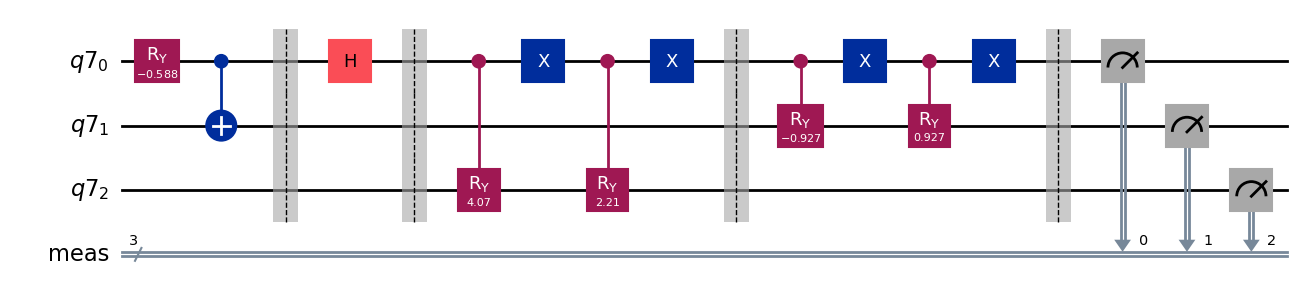

In [32]:
qc = qc_H(1.5,1.5,1)
qc.draw('mpl')

### Simulate circuit $V$ with aer simulator

In [33]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 100000

# Generate circuit
qc = qc_V(h_A,h_B,k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Simulate circuit H with aer simulator

In [34]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 100000

# Generate circuit
qc = qc_H(h_A,h_B,k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Show results for simulated circuit V

Exact E_A =  1.451024459240656
Alice's local energy =  1.4537544592406562 ± 0.004743408634199672
Interacting energy, V =  0.8132314459602311 ± 0.0024855486257812746


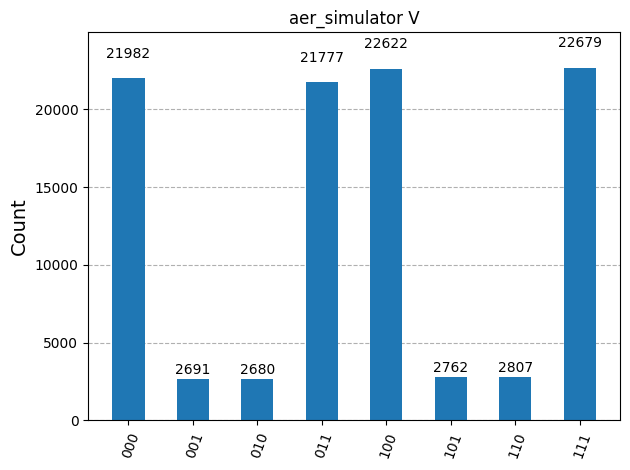

In [ ]:

result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()


ene_A = (h**2)/(np.sqrt(h**2+k**2))
ene_V = (2*k**2)/(np.sqrt(h**2+k**2))

error_A = []
error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += h*(-1)**int(bit_string[0])*count/n_shots
        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Exact E_A = ",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Interacting energy, V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')

Exact E_0 =  1.451024459240656
Alice's local energy =  0.6447597596625139 ± 0.004743416443767087
Bob's local energy, H_1 =  0.006291689975966252 ± 0.003711461374714816


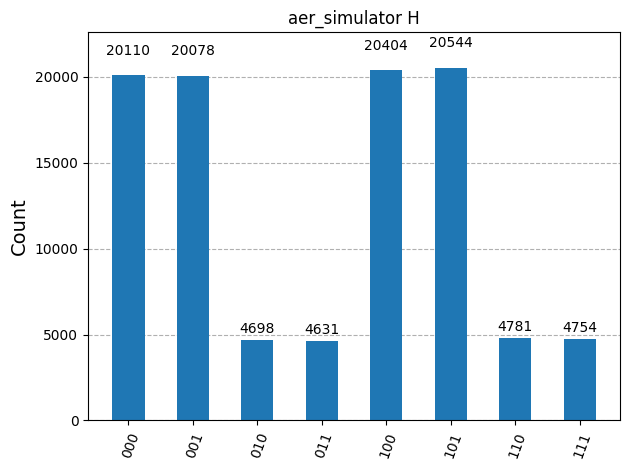

In [ ]:
result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

ene_A = (h_A**2)/(np.sqrt(h**2+k**2))
ene_B = (h_B**2)/(np.sqrt(h**2+k**2))
h_C = 0.786

error_A = []
error_B = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_B += h_B*(-1)**int(bit_string[1])*count/n_shots
        ene_A += h_A*(-1)**int(bit_string[0])*count/n_shots

        for i in range(count):
            error_A.append(h*(-1)**int(bit_string[0]))
            error_B.append(h*(-1)**int(bit_string[1]))

print("Exact E_0 = ",h**2/np.sqrt(h**2+k**2))
print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("Bob's local energy, H_1 = ",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")